<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/tfm_v0_7_051122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from  google.colab import drive
 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [78]:
#Imports
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

# Keras
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import imagenet_utils
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory


import matplotlib.pyplot as plt; 
import matplotlib.image as img
import matplotlib.patches as patches
from numpy.core.fromnumeric import argmax


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

##Data analysis

In [4]:
test_img_path = '/content/drive/MyDrive/IA3/TFM/archive/images/BikesHelmets0.png'
test_dat_path = '/content/drive/MyDrive/IA3/TFM/archive/annotations/BikesHelmets0.xml'

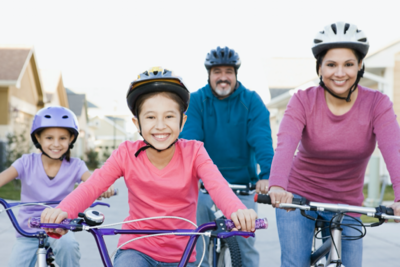

In [10]:
#Visualizamos la primera imagen del dataset
cv2_imshow(cv2.imread(test_img_path))

In [11]:
#Visualizamos el xml con los bounding boxes la primera imagen del dataset
xml_file = open(test_dat_path)
print(xml_file.read())


<annotation>
    <folder>images</folder>
    <filename>BikesHelmets0.png</filename>
    <size>
        <width>400</width>
        <height>267</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>With Helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>29</xmin>
            <ymin>105</ymin>
            <xmax>82</xmax>
            <ymax>160</ymax>
        </bndbox>
    </object>
    <object>
        <name>With Helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>122</xmin>
            <ymin>66</ymin>
            <xmax>193</xmax>
            <ymax>154</ymax>
        </bndbox>
    </object>
    <object>
        <name>With Helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</tr

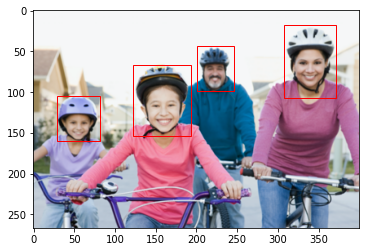

In [12]:
#Pintamos sobre la imagen los bounding boxes
fig, ax = plt.subplots()

image = load_img(test_img_path)
ax.imshow(image)

tree=ET.parse(test_dat_path)

for element in tree.findall('object'):

    xmin = int(element.find("bndbox").find('xmin').text)
    ymin = int(element.find("bndbox").find('ymin').text)
    xmax = int(element.find("bndbox").find('xmax').text)
    ymax = int(element.find("bndbox").find('ymax').text)

    h = ymax - ymin
    w = xmax - xmin

    rect = patches.Rectangle((int(xmin), int(ymin)), int(w), int(h), linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.show()

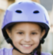

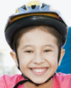

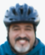

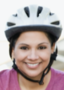

In [13]:
#Recortamos los bounding boxes de la imagen
tree=ET.parse(test_dat_path)

img = cv2.imread(test_img_path)

for element in tree.findall('object'):

    xmin = int(element.find("bndbox").find('xmin').text)
    ymin = int(element.find("bndbox").find('ymin').text)
    xmax = int(element.find("bndbox").find('xmax').text)
    ymax = int(element.find("bndbox").find('ymax').text)

    h = ymax - ymin
    w = xmax - xmin

    cropped_image = img[ymin:ymax, xmin:xmax, ]
    
    cv2_imshow(cropped_image)

    plt.show()

##Data preprocessing

In [14]:
#Recortamos todos los bounding boxes del dataset y los metemos en un nuevo
#directorio, concatenamos la clase a su nombre
bCropImages = 0
if(bCropImages):

  img_path      = '/content/drive/MyDrive/IA3/TFM/archive/images/'
  xml_path      = '/content/drive/MyDrive/IA3/TFM/archive/annotations/'
  img_crop_path = '/content/drive/MyDrive/IA3/TFM/archive/croppedImages0/'
  cont=[0,0]
  cont_element = 0

  contenido = os.listdir(img_path)

  for fichero in contenido:
    if fichero.endswith('.png'):
      
      img = cv2.imread(img_path+fichero)
      tree=ET.parse(xml_path+fichero[:-3]+'xml')

      cont_element = 0

      for element in tree.findall('object'):

        clase = int(np.invert('Without' in element.find("name").text))
        xmin = int(element.find("bndbox").find('xmin').text)
        ymin = int(element.find("bndbox").find('ymin').text)
        xmax = int(element.find("bndbox").find('xmax').text)
        ymax = int(element.find("bndbox").find('ymax').text)

        h = ymax - ymin
        w = xmax - xmin

        # Cropping an image
        cropped_image = img[ymin:ymax, xmin:xmax]

        if cropped_image.shape[0]==0 and cropped_image.shape[1]==0:
          print(fichero + ' object: ' + str(cont_element) + ' is empty!')
        else:
          cv2.imwrite(img_crop_path + str(clase) + '_' + str(cont[clase]) + '_' + fichero[:-4] + '.png', cropped_image)
          cont[clase] = cont[clase] + 1
        
        cont_element = cont_element +1



In [15]:
#Eliminamos estas imagenes ya que vemos que esta incorrecta alguna etiqueta

wrong_label_images =['BikesHelmets78.',
                     'BikesHelmets601.',
                     'BikesHelmets573.',
                     'BikesHelmets517.',
                     'BikesHelmets424.',
                     'BikesHelmets375.',
                     'BikesHelmets291.',
                     'BikesHelmets154.',
                     'BikesHelmets752.',
                     'BikesHelmets186.',
                     'BikesHelmets182.',
                     'BikesHelmets45.',
                     'BikesHelmets296.',
                     'BikesHelmets281.',
                     'BikesHelmets446.']
wrong_label_images

['BikesHelmets78.',
 'BikesHelmets601.',
 'BikesHelmets573.',
 'BikesHelmets517.',
 'BikesHelmets424.',
 'BikesHelmets375.',
 'BikesHelmets291.',
 'BikesHelmets154.',
 'BikesHelmets752.',
 'BikesHelmets186.',
 'BikesHelmets182.',
 'BikesHelmets45.',
 'BikesHelmets296.',
 'BikesHelmets281.',
 'BikesHelmets446.']

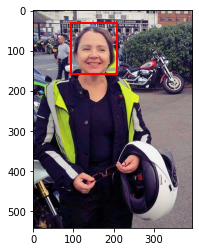

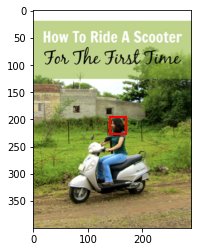

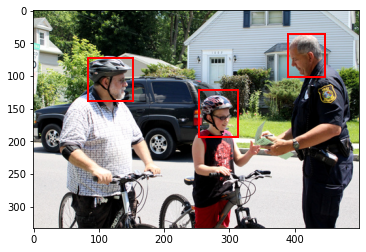

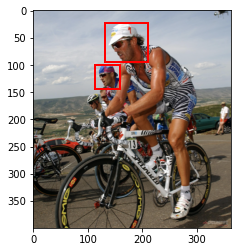

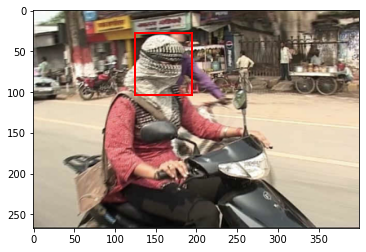

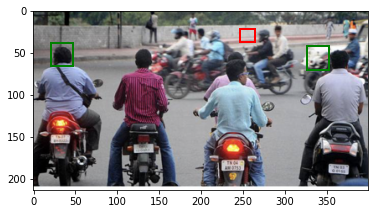

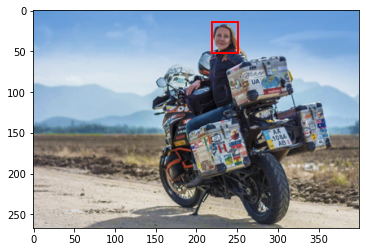

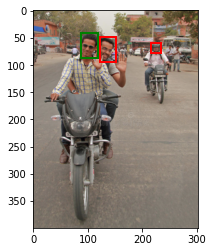

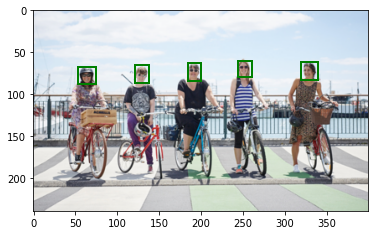

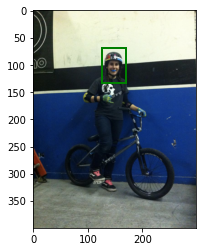

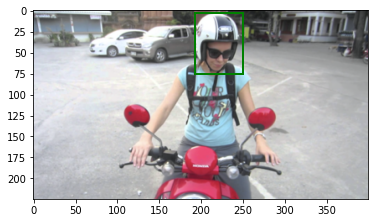

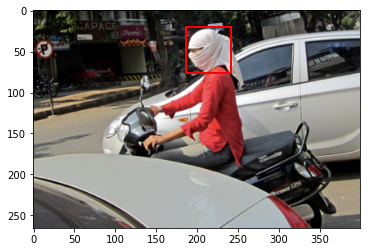

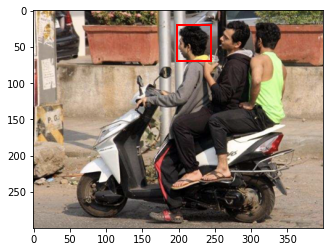

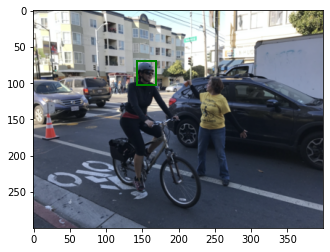

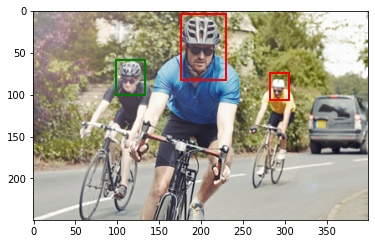

In [16]:
#Mostramos los fallos de etiquetado
#Pintamos de rojo la etiqueta 'with helmet' y de verde 'without helmet'

img_path      = '/content/drive/MyDrive/IA3/TFM/archive/images/'
xml_path      = '/content/drive/MyDrive/IA3/TFM/archive/annotations/'
img_crop_path = '/content/drive/MyDrive/IA3/TFM/archive/croppedImages0/'

for my_img in wrong_label_images:

  fig, ax = plt.subplots()

  image = load_img(img_path+my_img+'png')
  ax.imshow(image)

  tree=ET.parse(xml_path+my_img+'xml')

  for element in tree.findall('object'):

      if('With Helmet' in element.find("name").text):
        colorHelmet = 'r'
      else:
        colorHelmet = 'g'

      xmin = int(element.find("bndbox").find('xmin').text)
      ymin = int(element.find("bndbox").find('ymin').text)
      xmax = int(element.find("bndbox").find('xmax').text)
      ymax = int(element.find("bndbox").find('ymax').text)

      h = ymax - ymin
      w = xmax - xmin

      rect = patches.Rectangle((int(xmin), int(ymin)), int(w), int(h), linewidth=2, edgecolor=colorHelmet, facecolor='none')

      ax.add_patch(rect)

  plt.show()

In [17]:
#Recortamos todos los bounding boxes del dataset y los metemos en un nuevo
#directorio, concatenamos la clase a su nombre
#Ahora añadimos dos condiciones
#no estar en la lista de imagenes wrong_label_images
#dimensiones minimas (24x24) para que se la imagen sea minimamente inteligible

bCropImages = 0
if(bCropImages):

  img_path      = '/content/drive/MyDrive/IA3/TFM/archive/images/'
  xml_path      = '/content/drive/MyDrive/IA3/TFM/archive/annotations/'
  img_crop_path = '/content/drive/MyDrive/IA3/TFM/archive/croppedImages1/'
  cont=[0,0]
  cont_element = 0

  contenido = os.listdir(img_path)

  for fichero in contenido:
    
    if fichero[:-3] in wrong_label_images:
      print('Omitida:' + fichero) 
    else:
      if fichero.endswith('.png'):
        
        img = cv2.imread(img_path+fichero)
        tree=ET.parse(xml_path+fichero[:-3]+'xml')

        cont_element = 0

        for element in tree.findall('object'):

          clase = int(np.invert('Without' in element.find("name").text))
          xmin = int(element.find("bndbox").find('xmin').text)
          ymin = int(element.find("bndbox").find('ymin').text)
          xmax = int(element.find("bndbox").find('xmax').text)
          ymax = int(element.find("bndbox").find('ymax').text)

          h = ymax - ymin
          w = xmax - xmin

          # Cropping an image
          cropped_image = img[ymin:ymax, xmin:xmax]

          if cropped_image.shape[0]==0 and cropped_image.shape[1]==0:
            print(fichero + ' object: ' + str(cont_element) + ' is empty!')
          else:
            if(h<24) or (w<24):
              print(fichero + ' object: ' + str(cont_element) + ' is too small!')
            else:
              cv2.imwrite(img_crop_path + str(clase) + '__' + str(cont[clase]) + '_' + fichero[:-4] + '.png', cropped_image)
              cont[clase] = cont[clase] + 1
          
          cont_element = cont_element +1

##Data augmentation

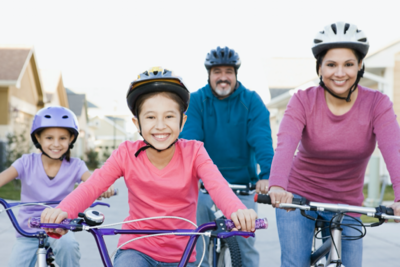

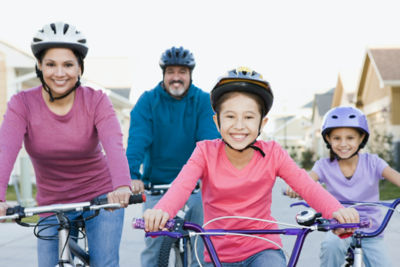

In [20]:
#Para aumentar nuestras muestras usamos flip en todas ellas como herramienta

image = cv2.imread(test_img_path)
cv2_imshow(image)
image=cv2.flip(image, 2)
cv2_imshow(image) 

In [ ]:
#Se guardan en un nuevo directorio las muestras + las aumentadas

bFlipImages = 0
img_path = '/content/drive/MyDrive/IA3/TFM/archive/croppedImages1/'
img_path_out = '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/'

if(bFlipImages):

  for fichero in os.listdir(img_path):
    img = cv2.imread(img_path+fichero)
    imgFlip = cv2.flip(img, 2)
    cv2.imwrite(img_path_out+fichero[:-4]+'_orig'+'.png', img)
    cv2.imwrite(img_path_out+fichero[:-4]+'_flip'+'.png', imgFlip)

print('cropped images: ', len(os.listdir(img_path)))
print('augment images: ', len(os.listdir(img_path_out)))

##Training and test

In [31]:
#Creamos listas con todos los nombres de los ficheros 

data_path = '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/'

data_0=[]
data_1=[]

for img in os.listdir(data_path):
  if '0__' in img:
    data_0.append(os.path.join(data_path,img))
  else:
    data_1.append(os.path.join(data_path,img))

print('ej: ', data_0[0])

print('Total: ', len(os.listdir(data_path)))
print('Clase 0 (Without helmet): ', len(data_0))
print('Clase 1 (With helmet): ', len(data_1))

ej:  /content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/0__178_BikesHelmets531_orig.png
Total:  2200
Clase 0 (Without helmet):  624
Clase 1 (With helmet):  1576


In [42]:
#Hacemos la division de las muestras train test y val: 60,20,20 

train_0, test_0 = train_test_split(data_0, test_size=0.4)
test_0, val_0 = train_test_split(test_0, test_size=0.5)

print('Clase 0:',len(data_0), ' - train:',len(train_0), 'test:',len(test_0),'val:', len(val_0))

train_1, test_1 = train_test_split(data_1, test_size=0.4)
test_1, val_1 = train_test_split(test_1, test_size=0.5)

print('Clase 1:', len(data_1), '- train:',len(train_1), 'test:',len(test_1), 'val:',len(val_1))

Clase 0: 624  - train: 374 test: 125 val: 125
Clase 1: 1576 - train: 945 test: 315 val: 316


In [43]:
#Ejemplos de las rutas 
train_0[0:3]

['/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/0__214_BikesHelmets578_orig.png',
 '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/0__163_BikesHelmets487_flip.png',
 '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/0__149_BikesHelmets493_orig.png']

In [44]:
#Ejemplos de las rutas 
train_1[0:3]

['/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/1__301_BikesHelmets330_orig.png',
 '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/1__491_BikesHelmets489_flip.png',
 '/content/drive/MyDrive/IA3/TFM/archive/croppedImagesAug/1__453_BikesHelmets460_orig.png']

In [45]:
num_classes = 2
y = []

for img in train_0:
  y.append(0) 

y_train_0 = np_utils.to_categorical(y, num_classes)

In [46]:
y = []

for img in train_1:
  y.append(1) 

y_train_1 = np_utils.to_categorical(y, num_classes)

In [47]:
y = []

for img in test_0:
  y.append(0) 

y_test_0 = np_utils.to_categorical(y, num_classes)

In [48]:
y = []

for img in test_1:
  y.append(1) 

y_test_1 = np_utils.to_categorical(y, num_classes)

In [49]:
y = []

for img in val_0:
  y.append(0) 

y_val_0 = np_utils.to_categorical(y, num_classes)

In [50]:
y = []

for img in val_1:
  y.append(1) 

y_val_1 = np_utils.to_categorical(y, num_classes)

In [51]:
y_train = np.concatenate([y_train_0, y_train_1])
y_test = np.concatenate([y_test_0, y_test_1])
y_val = np.concatenate([y_val_0, y_val_1])
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1319, 2)
(440, 2)
(441, 2)


In [52]:
train = train_0 + train_1
test = test_0 + test_1
val = val_0 + val_1
print(len(train))
print(len(test))
print(len(val))


1319
440
441


In [59]:
test_y=[]

for i in y_test:
  test_y.append(np.argmax(i))

In [53]:
#Clase para mostrar imagenes
def show_imgs(X):
    plt.figure(figsize=(14, 14))
    k = 0
    #k= np.random.randint(0, len(X)-1-16)

    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            ax = plt.subplot2grid((4,4),(i,j))
            #ax.set_title('Clase: ' + str(y_train[k]) ) 
            if(y_train[k][0]):
              ax.set_title('Clase: ' + str(y_train[k]) + ' Without Helment') 
            else:
              ax.set_title('Clase: ' + str(y_train[k]) + ' With Helment') 
            plt.subplots_adjust(hspace=0.5)    
            plt.imshow(image)            
            #k = k+1
            k= np.random.randint(0, len(X)-1-16)
    #Muestra
    plt.show()

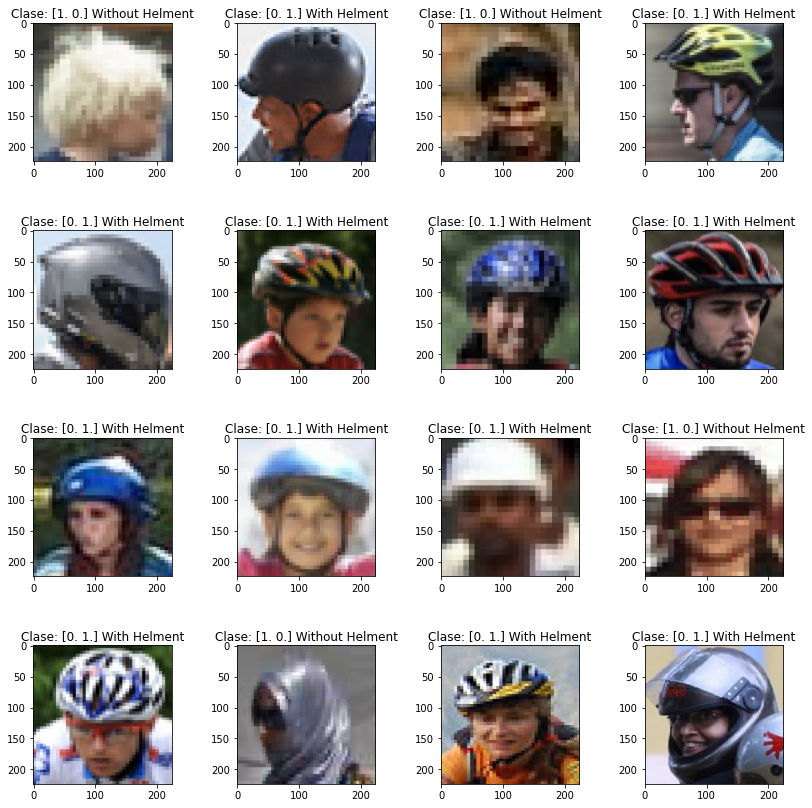

In [56]:
#Para visualizar nuestras muestras
show_imgs(train)


In [57]:
#Para preparar el conjunto de muestras
def create_features(dataset):
 
    x_scratch = []

    k=0

    #Bucle sobre las imagenes
    for imagePath in dataset:
 
        #Se cargan las imagenes a tamaño 224
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)

        k = k+1
        #print('convertida:', k, ' de ', len(dataset))
 
    x = np.vstack(x_scratch)
    return x

In [58]:
#obtenemos los arrays de cada conjunto
train_x = create_features(train)
val_x = create_features(val)
test_x = create_features(test)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1319, 224, 224, 3)
(441, 224, 224, 3)
(440, 224, 224, 3)


In [60]:
#probamos un modelo simple, que entrenaremos desde cero

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=train_x.shape[1:]))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer="l2")) # regularizador L2
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

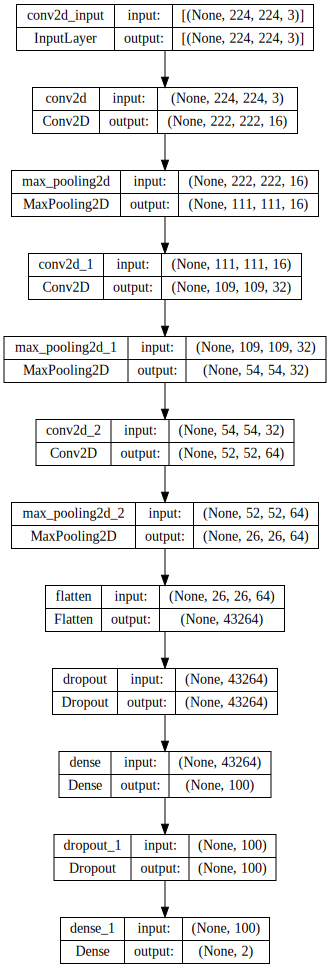

In [61]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [62]:
checkpointer = ModelCheckpoint(filepath='model.best.hdf5',
                               verbose=1,save_best_only=True)

In [63]:
history = model.fit(train_x, y_train, batch_size=32, epochs=50,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 10.5072 - accuracy: 0.6194
Epoch 1: val_loss improved from inf to 4.22960, saving model to model.best.hdf5
42/42 [==============================] - 11s 59ms/step - loss: 10.5072 - accuracy: 0.6194 - val_loss: 4.2296 - val_accuracy: 0.7302
Epoch 2/50
41/42 [============================>.] - ETA: 0s - loss: 6.2603 - accuracy: 0.6479
Epoch 2: val_loss improved from 4.22960 to 2.83909, saving model to model.best.hdf5
42/42 [==============================] - 2s 42ms/step - loss: 6.2544 - accuracy: 0.6482 - val_loss: 2.8391 - val_accuracy: 0.7460
Epoch 3/50
41/42 [============================>.] - ETA: 0s - loss: 4.1090 - accuracy: 0.6928
Epoch 3: val_loss improved from 2.83909 to 2.45575, saving model to model.best.hdf5
42/42 [==============================] - 2s 43ms/step - loss: 4.1158 - accuracy: 0.6929 - val_loss: 2.4557 - val_accuracy: 0.7596
Epoch 4/50
41/42 [============================>.] - ETA: 0s - loss: 3.5185 - 

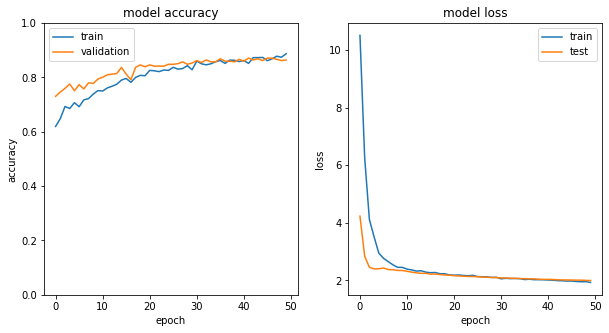

In [64]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))
 
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0, 1])
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_accuracy_loss(history)

In [65]:
preds = np.argmax(model.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,num_classes))

14/14 [==============================] - 0s 27ms/step

Accuracy on Test Data:  0.8590909090909091

Number of correctly identified imgaes:  378 



array([[ 89,  36],
       [ 26, 289]])

14/14 [==============================] - 0s 17ms/step
Model
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       125
           1       0.89      0.92      0.90       315

    accuracy                           0.86       440
   macro avg       0.83      0.81      0.82       440
weighted avg       0.86      0.86      0.86       440



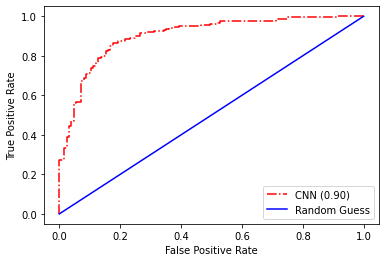

In [66]:
y_pred_proba = model.predict(test_x)
y_pred = np.argmax(y_pred_proba, axis=1)
print('Model')
print(classification_report(test_y, y_pred))

clase_positiva = 1
#fpr, tpr, thresholds = roc_curve(test_y==clase_positiva, y_pred_proba[:,clase_positiva])
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

In [67]:
scores_tr = model.evaluate(x=train_x, y=y_train)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_te = model.evaluate(x=test_x, y=y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

scores_val = model.evaluate(x=val_x, y=y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

42/42 [==============================] - 1s 19ms/step - loss: 1.8535 - accuracy: 0.9196
Train loss    : 1.85347580909729
Train accuracy: 0.919636070728302

14/14 [==============================] - 0s 18ms/step - loss: 2.0008 - accuracy: 0.8591
Test loss     : 2.00079345703125
Test accuracy : 0.8590909242630005
14/14 [==============================] - 0s 18ms/step - loss: 1.9941 - accuracy: 0.8639
Val loss    : 1.9941242933273315
Val accuracy: 0.8639456033706665



In [68]:
# Creating a checkpointer
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5',
                               verbose=1,save_best_only=True)
# load the VGG16 network
print("[INFO loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()

[INFO loading network...
58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                     

In [69]:
# Freeze the layers except the last 9 layers
#for layer in model_vgg.layers[:-9]:
    #layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe420328cd0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe42074d8d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe436a17490> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe431b280d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe420270110> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe42074d510> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe4203264d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe42074df10> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe420285ed0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe420285350> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fe42028b950> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe420285850> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fe420299b50> True
<keras.layers.convolutional.conv2d.

In [70]:
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(100, activation='relu'))
model_transfer_full.add(Dense(num_classes, activation='softmax'))
model_transfer_full.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               51300     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 14,766,190
Trainable params: 14,766,190
Non-trainable params: 0
__________________________________________

In [71]:
opt = Adam(learning_rate=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_full.fit(train_x, y_train, batch_size=32, epochs=10,
          validation_data=(val_x, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.6861
Epoch 1: val_loss improved from inf to 0.42634, saving model to scratchmodel.best.hdf5
42/42 [==============================] - 35s 662ms/step - loss: 0.7429 - accuracy: 0.6861 - val_loss: 0.4263 - val_accuracy: 0.7959
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8309
Epoch 2: val_loss improved from 0.42634 to 0.33686, saving model to scratchmodel.best.hdf5
42/42 [==============================] - 23s 549ms/step - loss: 0.3718 - accuracy: 0.8309 - val_loss: 0.3369 - val_accuracy: 0.8390
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.8764
Epoch 3: val_loss improved from 0.33686 to 0.21179, saving model to scratchmodel.best.hdf5
42/42 [==============================] - 22s 529ms/step - loss: 0.2795 - accuracy: 0.8764 - val_loss: 0.2118 - val_accuracy: 0.9229
Epoch 4/10
42/42 [==============================] - E

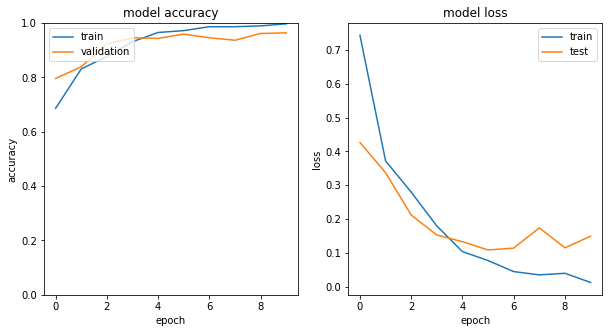

In [72]:
plot_accuracy_loss(history)

In [73]:

preds = np.argmax(model_transfer_full.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,num_classes))

14/14 [==============================] - 5s 345ms/step

Accuracy on Test Data:  0.9590909090909091

Number of correctly identified imgaes:  422 



array([[121,   4],
       [ 14, 301]])

14/14 [==============================] - 2s 165ms/step
Model transfer
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       125
           1       0.99      0.96      0.97       315

    accuracy                           0.96       440
   macro avg       0.94      0.96      0.95       440
weighted avg       0.96      0.96      0.96       440



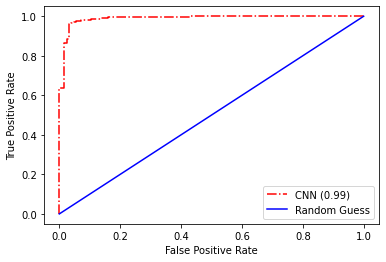

In [74]:
y_pred_proba = model_transfer_full.predict(test_x)
y_pred = np.argmax(y_pred_proba, axis=1)
print('Model transfer')
print(classification_report(test_y, y_pred))

fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

In [76]:
scores_tr = model_transfer_full.evaluate(x=train_x, y=y_train)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_te = model_transfer_full.evaluate(x=test_x, y=y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

scores_val = model_transfer_full.evaluate(x=val_x, y=y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

42/42 [==============================] - 7s 166ms/step - loss: 0.0084 - accuracy: 0.9985
Train loss    : 0.008403764106333256
Train accuracy: 0.9984837174415588

14/14 [==============================] - 2s 168ms/step - loss: 0.1511 - accuracy: 0.9591
Test loss     : 0.15114594995975494
Test accuracy : 0.9590908885002136
14/14 [==============================] - 2s 170ms/step - loss: 0.1492 - accuracy: 0.9637
Val loss    : 0.14918124675750732
Val accuracy: 0.963718831539154



##Validation

Ground truth:  1   With helmet
1/1 [==============================] - 0s 18ms/step
Predict:       1   With helmet


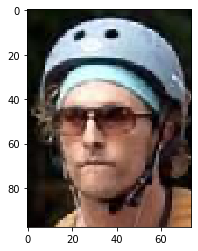

In [94]:
classes_names = ('Without helmet','With helmet')

id=np.random.randint(0, len(val)-1)

image = img.imread(val[id])

plt.imshow(image[:,:,:], cmap='gray', vmin = 0, vmax = 255,interpolation='none')
print("Ground truth: ", y_val[id].argmax(), " ", classes_names[y_val[id].argmax()])
#plt.imshow(train_x[id])

p = model_transfer_full.predict(np.expand_dims(val_x[id], axis=0))
print("Predict:      ", p.argmax(), " ", classes_names[p.argmax()])